# Exam model

I Mira Vorne assure that I have done the exercise independently and I have carefully followed all the rules of the exam. I understand serious consequences in case of acting against the rules

Let's see what the material looks like first. With random images with labels is good way to check out few images.

x_test shape: (7000, 28, 28)
y_test shape: (7000,)


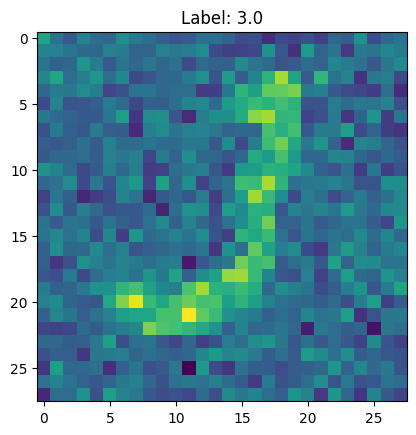

In [42]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, callbacks
import cv2

tallennustiedosto_testi = open('mnist.hupsista', 'rb')
[X_train, y_train] = pickle.load(tallennustiedosto_testi)
tallennustiedosto_testi.close()

X_train = X_train.astype('float32') / 255.0

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print("x_test shape:", X_train.shape)
print("y_test shape:", y_train.shape)

# get random images with their labels to see what the data looks like
random_index = np.random.randint(0, len(X_train))

plt.imshow(X_train[random_index])
plt.title(f'Label: {y_train[random_index]}')
plt.show()

Now we'll check all the labels used.

In [43]:
# List all unique labels
unique_labels = np.unique(y_train)

print("Unique labels in y_train:", unique_labels)

Unique labels in y_train: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


The training/validation data is certainly not good... It seems like we have a challenging task at hand! I'll start by trying to design a machine learning model that can handle the variations of the data. 

After studying some options, I decided to start with a CNN model and sparse categorical crossentropy loss function. The model architecture is inspired by the simple and traditional LeNet-5 architecture, with few enhanchements. 

I will try to find optimal kernel size, so I don't use too much computing power, but will get good enough results. 

In the output layer, I'll use softmax activation function. In the multi-class classification problem, where each input can belong to one of many possible classes, the softmax function is apparently generally a good choice. 

I'm going to use Adam optimizer, which has the default learning rate is 0.001. I'll stick to the default for now. 

I also tried the tanh activation function, but ended up using ReLU, since it worked better.

Resources used for planning the first model:
* https://www.tensorflow.org/guide/keras/sequential_model
* https://www.tensorflow.org/tutorials/images/cnn
* https://keras.io/guides/training_with_built_in_methods/
* https://poloclub.github.io/cnn-explainer/

In [44]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)), #  Take the maximum value in each 2x2 window.
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(), # Convert from 2D matrix into a 1D vector, because Dense layers expect input in this format.
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3611 - loss: 1.9522 - val_accuracy: 0.4687 - val_loss: 1.7473
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4814 - loss: 1.6276 - val_accuracy: 0.4837 - val_loss: 1.5865
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5174 - loss: 1.4368 - val_accuracy: 0.5050 - val_loss: 1.4361
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5507 - loss: 1.2870 - val_accuracy: 0.5307 - val_loss: 1.3459
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5914 - loss: 1.1625 - val_accuracy: 0.5433 - val_loss: 1.3075
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6273 - loss: 1.0597 - val_accuracy: 0.5510 - val_loss: 1.2851
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6581 - loss: 0.9618 - val_accuracy: 0.5670 - val_loss: 1.2712
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6909 - loss: 0.8645 - val_accuracy: 0.

Not bad for the first try. Figures show a bit of overfitting. Let's plot some images for visual analysis.

I'm expecting to plot several times, so maybe it is good to make a plotting function now, so I can use it through the whole experiment.

In [45]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

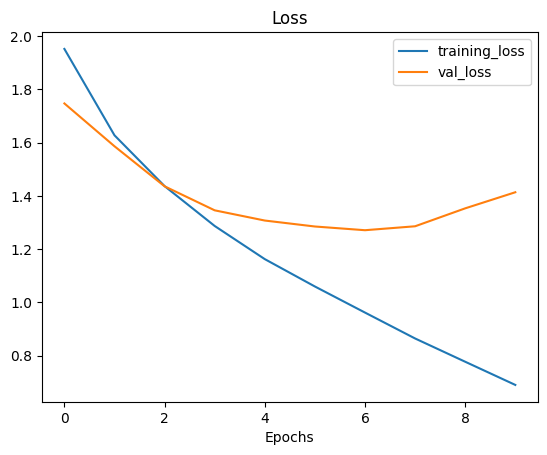

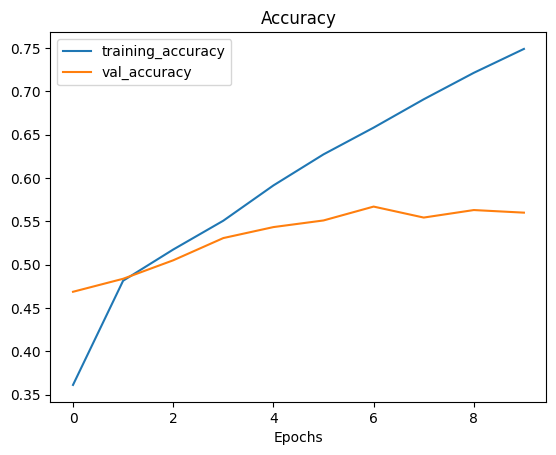

In [46]:
# Check out our model's performance 
plot_loss_curves(history)

Ok, let's do some further experiment... I'll just add a dropout layer to help with the overfitting.

In [47]:
# Create the model 
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout layer for regularization and preventing overfitting
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_2 = model_2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2819 - loss: 2.0725 - val_accuracy: 0.4387 - val_loss: 1.8004
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4357 - loss: 1.7705 - val_accuracy: 0.4923 - val_loss: 1.5853
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4866 - loss: 1.5579 - val_accuracy: 0.5110 - val_loss: 1.4110
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5101 - loss: 1.4258 - val_accuracy: 0.5330 - val_loss: 1.3318
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5270 - loss: 1.3238 - val_accuracy: 0.5570 - val_loss: 1.2695
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5561 - loss: 1.2448 - val_accuracy: 0.5587 - val_loss: 1.2342
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5803 - loss: 1.1797 - val_accuracy: 0.5683 - val_loss: 1.2042
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 1.1154 - val_accuracy: 0.

And check:

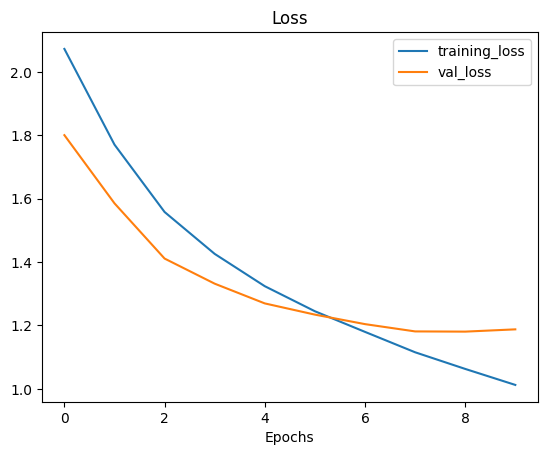

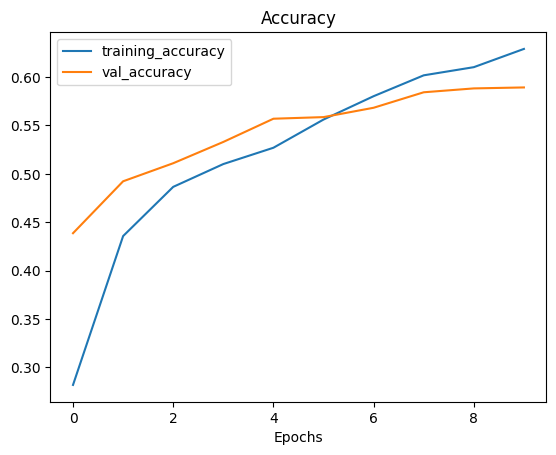

In [48]:
plot_loss_curves(history_2)

The figure seems better. Now I want to see what happens if I increase the dropout rate. It should increase the amount of regularization. 

In [49]:
# Create the model architecture
model_3 = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),  # Adding dropout layer for regularization and preventing overfitting
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_3 = model_3.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2590 - loss: 2.1107 - val_accuracy: 0.4337 - val_loss: 1.8560
Epoch 2/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4173 - loss: 1.7929 - val_accuracy: 0.5117 - val_loss: 1.5848
Epoch 3/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4689 - loss: 1.6053 - val_accuracy: 0.5213 - val_loss: 1.4370
Epoch 4/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4904 - loss: 1.4803 - val_accuracy: 0.5287 - val_loss: 1.3414
Epoch 5/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5006 - loss: 1.4041 - val_accuracy: 0.5343 - val_loss: 1.2967
Epoch 6/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5164 - loss: 1.3385 - val_accuracy: 0.5387 - val_loss: 1.2578
Epoch 7/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5313 - loss: 1.2973 - val_accuracy: 0.5493 - val_loss: 1.2158
Epoch 8/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5356 - loss: 1.2618 - val_accuracy: 0.

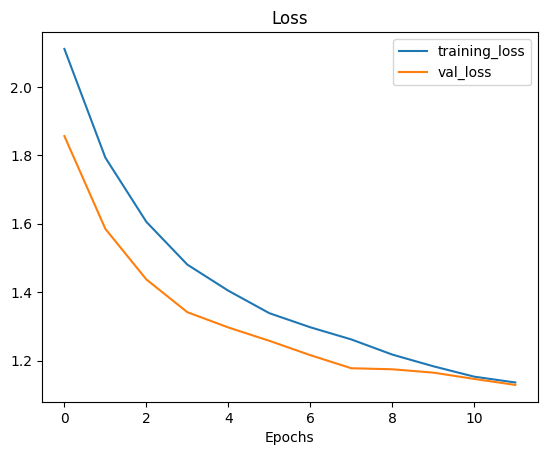

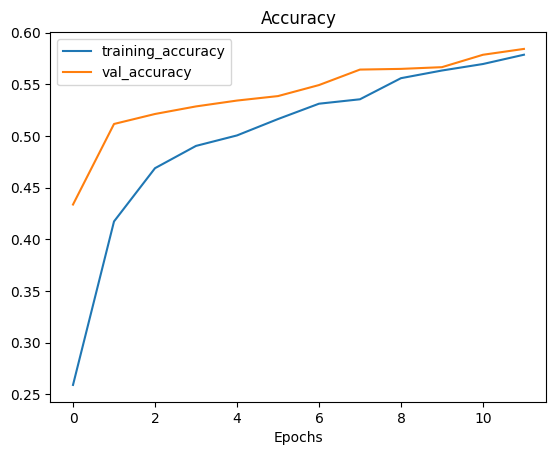

In [50]:
# Check out our model's performance 
plot_loss_curves(history_3)

Let's add early stopping callback. I'll add it to the model_2, with 0.5 dropout rate.

In [51]:
# Create the model
model_4 = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout layer for regularization
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with early stopping
history_4 = model_4.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping])


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2661 - loss: 2.0902 - val_accuracy: 0.4257 - val_loss: 1.8321
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4190 - loss: 1.8099 - val_accuracy: 0.4750 - val_loss: 1.6595
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4676 - loss: 1.6132 - val_accuracy: 0.5210 - val_loss: 1.4456
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4901 - loss: 1.4756 - val_accuracy: 0.5227 - val_loss: 1.3671
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5129 - loss: 1.3709 - val_accuracy: 0.5390 - val_loss: 1.3036
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5410 - loss: 1.3023 - val_accuracy: 0.5580 - val_loss: 1.2354
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5627 - loss: 1.2316 - val_accuracy: 0.5810 - val_loss: 1.2156
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5813 - loss: 1.1610 - val_accuracy: 0.

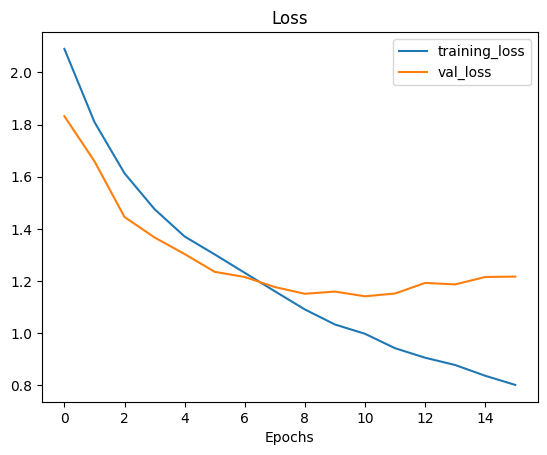

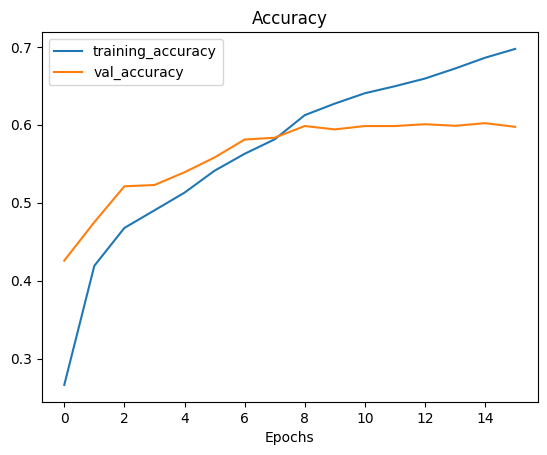

In [52]:
# Check out our model's performance 
plot_loss_curves(history_4)

Let's also try simpler architecture. 

In [53]:
# Create the model
model_5 = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_5 = model_5.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32) 

# Print model summary
model_5.summary()


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3014 - loss: 2.0506 - val_accuracy: 0.4417 - val_loss: 1.8188
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4464 - loss: 1.7379 - val_accuracy: 0.4633 - val_loss: 1.6803
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4890 - loss: 1.5475 - val_accuracy: 0.4933 - val_loss: 1.5219
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5233 - loss: 1.3885 - val_accuracy: 0.5247 - val_loss: 1.3900
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5533 - loss: 1.2676 - val_accuracy: 0.5417 - val_loss: 1.3489
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5864 - loss: 1.1810 - val_accuracy: 0.5580 - val_loss: 1.2690
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6087 - loss: 1.1133 - val_accuracy: 0.5710 - val_loss: 1.2207
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6271 - loss: 1.0548 - val_accuracy: 0.

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,280 (520.63 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,854 (347.09 KB)

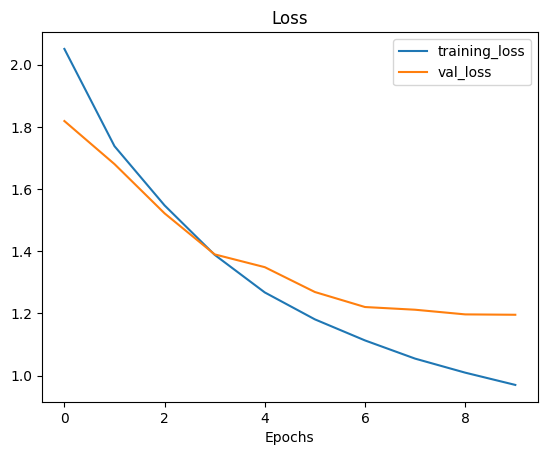

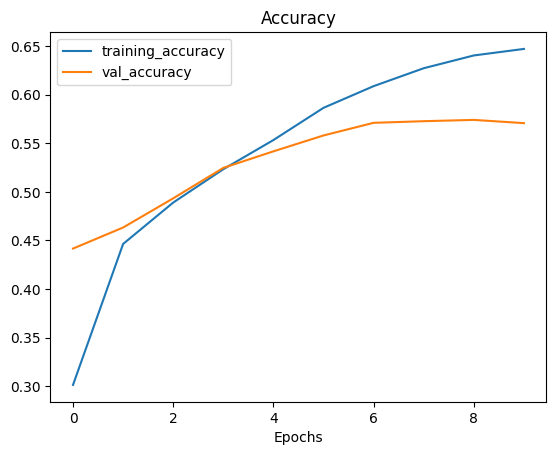

In [54]:
# Check out our model's performance 
plot_loss_curves(history_5)

Let's try and add dropout to the model_5

In [55]:

# Create the model
model_6 = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dropout(0.5),  # Add dropout with rate 0.5
    layers.Dense(84, activation='relu'), 
    layers.Dropout(0.5),  # Add dropout with rate 0.5
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Print model summary
model_6.summary()

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1651 - loss: 2.2391 - val_accuracy: 0.3243 - val_loss: 2.0564
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3184 - loss: 1.9972 - val_accuracy: 0.4317 - val_loss: 1.8164
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3959 - loss: 1.8129 - val_accuracy: 0.4833 - val_loss: 1.6424
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4373 - loss: 1.6746 - val_accuracy: 0.5107 - val_loss: 1.4795
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4654 - loss: 1.5460 - val_accuracy: 0.5203 - val_loss: 1.3873
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4840 - loss: 1.4774 - val_accuracy: 0.5267 - val_loss: 1.3361
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4974 - loss: 1.4229 - val_accuracy: 0.5370 - val_loss: 1.2942
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5131 - loss: 1.3783 - val_accuracy: 0.

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,280 (520.63 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,854 (347.09 KB)

What could I try next? Maybe try adding early stopping.

In [56]:
# Create the model
model_7 = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dropout(0.5),  # Add dropout with rate 0.5
    layers.Dense(84, activation='relu'),
    layers.Dropout(0.5),  # Add dropout with rate 0.5
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history_7 = model_7.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping])

# Print model summary
model_7.summary()

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1437 - loss: 2.2741 - val_accuracy: 0.2807 - val_loss: 2.1316
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2923 - loss: 2.0494 - val_accuracy: 0.3997 - val_loss: 1.8613
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3610 - loss: 1.8736 - val_accuracy: 0.4627 - val_loss: 1.6773
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4184 - loss: 1.7188 - val_accuracy: 0.4647 - val_loss: 1.5538
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4461 - loss: 1.6094 - val_accuracy: 0.5023 - val_loss: 1.4218
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4701 - loss: 1.5223 - val_accuracy: 0.5117 - val_loss: 1.3642
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4881 - loss: 1.4572 - val_accuracy: 0.5303 - val_loss: 1.3102
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5061 - loss: 1.4015 - val_accuracy: 0.

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,280 (520.63 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,854 (347.09 KB)

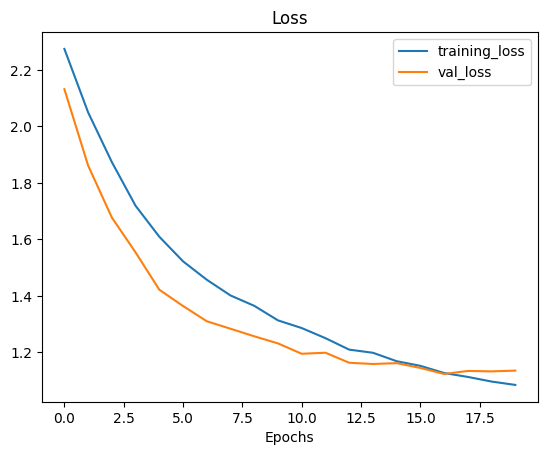

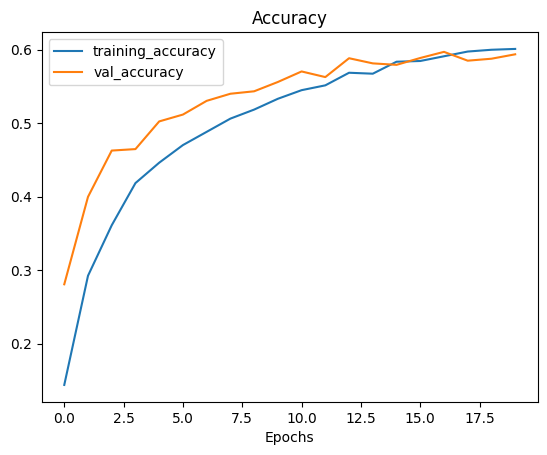

In [57]:
plot_loss_curves(history_7)

Let's try something else.

The model might learn to recognize the digits. Data augmentation and adding more training data would be another option, but since preprocessing of the data is not allowed anyway, I will not use my time on doing that. 

So, I'll just fiddle with the model and see, what will happen. 

In [58]:
# Create the model 
model_9 = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(6, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(84, activation='relu'),
    layers.Dropout(0.5),  # Add dropout with rate 0.5
    layers.Dense(120, activation='relu'),
    layers.Dropout(0.5),  # Add dropout with rate 0.5
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_9 = model_9.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=32)

# Print model summary
model_9.summary()


Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1521 - loss: 2.2579 - val_accuracy: 0.3620 - val_loss: 2.0828
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3010 - loss: 2.0406 - val_accuracy: 0.4300 - val_loss: 1.8537
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3737 - loss: 1.9030 - val_accuracy: 0.4663 - val_loss: 1.7616
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4149 - loss: 1.8158 - val_accuracy: 0.4987 - val_loss: 1.6613
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4541 - loss: 1.7214 - val_accuracy: 0.5157 - val_loss: 1.5511
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4653 - loss: 1.6053 - val_accuracy: 0.5197 - val_loss: 1.4318
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4857 - loss: 1.5078 - val_accuracy: 0.5263 - val_loss: 1.3426
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4913 - loss: 1.4414 - val_accuracy: 0.

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 26, 26, 6)      │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 13, 13, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 11, 11, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 84)             │        33,684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 120)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 10)             │         1,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,104 (539.47 KB)

 Trainable params: 46,034 (179.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,070 (359.65 KB)

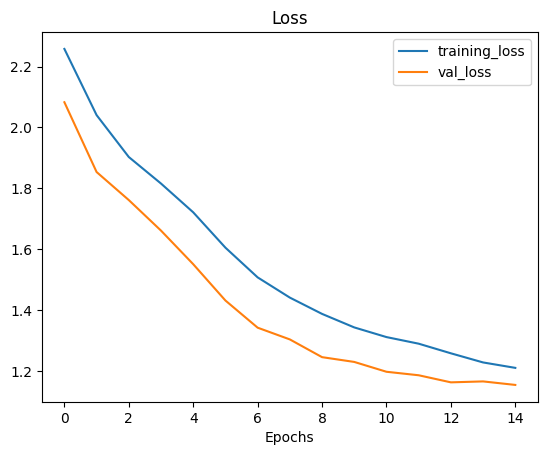

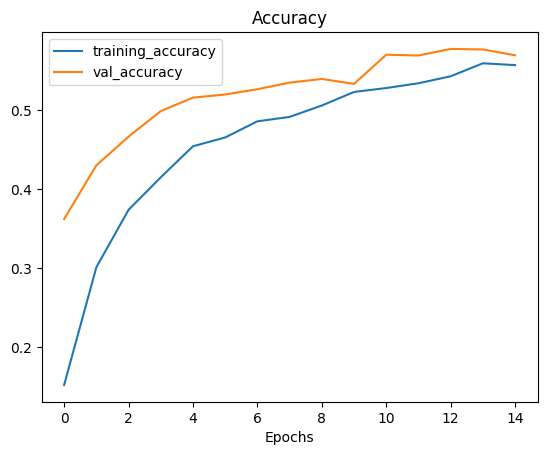

In [59]:
plot_loss_curves(history_9)

I guess I have tried different scenarios enough. I'm not happy about the model's valuation accuracy. The variation between possible outcomes is too high. I can only decrease the number of parameters as much as I can to get the best possible price with the poor accuracy. So, I'll just use this one. Let's save it.

In [60]:
model_9.save('MiraVorneExam.keras')